In [1]:
## Call pip install on 1st time only
# %%capture cap
# pip install geneticalgorithm
# pip install import-ipynb
# pip install git+https://github.com/hyperopt/hyperopt-sklearn.git
# pip install platypus-opt
# pip install numpy=1.19.5

# **Imports**

In [2]:
import os
# from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from scipy.stats import variation 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,SelectFromModel,RFE,chi2,mutual_info_classif,f_classif
import matplotlib.pyplot as plt
from sklearn import preprocessing,metrics
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score,auc,roc_curve
import math
from sklearn.utils import shuffle

# import statistics

# import import_ipynb

from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing, extra_trees,random_forest
from hyperopt import tpe

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# **Parameter Settings**

In [3]:
###--------------------------General--------------------------   

data_folder="./data_myron/"
ensembl_and_gene_names = "./R/data/Homo_sapiens.GRCh19.longest.GSE89843.ready.gtf"
data_path = data_folder + "GSE89843_TEP_Count_Matrix_annot_ready.txt"
labels_path = data_folder + "GSE89843_patients_characteristics_formatted_full.csv"
            
n_folds=5
# clf = LogisticRegression( solver='sag', multi_class='multinomial',random_state=42) 
clf =  RandomForestClassifier(n_estimators=100,random_state=42)

shuffle_random_seed = 20
verbose=True
##--------------------------normalization--------------------------
normalization_selected = "TPM" # "TPM" "TMM"  "ruvseq_diff"    "ruvseq_cv"
normalisation_method_chosen=normalization_selected
forced=True  # this parameter is to do normalization from scrach or reading those ones done befor
top_f=50
##--------------------------KBest--------------------------
mode_KBest ='iterative'  #or fixed  iterative
# mode_KBest ='fixed'  #or fixed  iterative

estimator_KBest_Iterative = LogisticRegression( solver='sag', multi_class='multinomial',random_state=42)
metric_of_KBest = mutual_info_classif   #chi2,mutual_info_classif,f_classif
k_KBest=1000
##--------------------------SelectFromModel--------------------------
estimator_SelectFromModel=RandomForestClassifier(n_estimators=100,random_state=42)
##--------------------------REF--------------------------
step_REF=1
estimator_RFE=RandomForestClassifier(n_estimators=100,random_state=42)
n_final_features_to_select=5
##--------------------------EVOFS--------------------------
estimator_EVOFS=LogisticRegression(solver='saga', multi_class='multinomial',random_state=42,penalty='l1')
score_func=mutual_info_classif   # chi2,mutual_info_classif,f_classif , it is recommended to set same as metric_of_KBest
min_features=2
max_generations=1000
##--------------------------skmoefs--------------------------
max_Evals=50000
##--------------------------Tunning--------------------------
max_evals_tunning=500
trial_timeout_tunning=300


#### Other classifires can be possibly used
# andomForestClassifier(n_estimators=100,random_state=42)
# AdaBoostClassifier()
# ExtraTreesClassifier(n_estimators=50)
# AdaBoostClassifier() 




# **Methods and Classes**

## **Result, PrintResult,MakeDF**

In [4]:
class Result:
    Score_train,Score_test,AUC_train,AUC_test,n_selceted_feature,n_Rules,state=0,0,0,0,0,0,''
    def __init__(self, Score_train=0, Score_test=0,AUC_train=0,AUC_test=0,n_selceted_feature=0,n_Rules=0,state=''):
        self.Score_train,self.Score_test,self.AUC_train,self.AUC_test,self.n_selceted_feature,self.n_Rules,self.state=Score_train,Score_test,AUC_train,AUC_test,n_selceted_feature,n_Rules,state

def PrintResults(results, state,DF_results):
  # print('\n'+ state + '....')
    scores = [r.Score_train for r in results if r.state==state]
    if len(scores)==0:
        S1=np.nan
    else:
        S1=sum(scores)/len(scores)
    scores = [r.Score_test for r in results if r.state==state]
    if len(scores)==0: 
        S2=np.nan 
        S8=np.nan
    else:
        S2=sum(scores)/len(scores)
        S8=np.std(scores)
    scores = [r.AUC_train for r in results if r.state==state]
    if len(scores)==0:
        S3=np.nan
    else:
        S3=sum(scores)/len(scores)
    scores = [r.AUC_test for r in results if r.state==state]
    if len(scores)==0:
        S4=np.nan
        S7=np.nan
    else:
        S4=sum(scores)/len(scores)
        S7=np.std(scores)
    NumOfFeatures = [r.n_selceted_feature for r in results if r.state==state]
    if len(NumOfFeatures)==0:
        S5=np.nan
    else:
        S5=sum(NumOfFeatures)/len(NumOfFeatures)       
    NumOfRules = [r.n_Rules for r in results if r.state==state]   
    if len(NumOfRules)==0:
        S6=np.nan
    else:
        S6=sum(NumOfRules)/len(NumOfRules)
        
    new_row = {'State':state, 'Train Acc':round(S1*100,2),'Train AUC':round(S3*100,2), 'Test Acc':round(S2*100,2),'STD':round(S8*100,2), 'Test AUC':round(S4*100,2), 'STD': round(S7*100,2) ,'# Features':S5, '# Rules':S6}
    DF_results = DF_results.append(new_row, ignore_index=True) 
  # print('\n'+ state + '....')
  # print('Average Score_train: {}'.format(S1) + '  Average Score_test : {}'.format(S2) + '  NumOfFeatures : {}'.format(S3))
    return DF_results

def MakeDF(data_array,old_df,cols):
    # cols = old_df.columns[selector.get_support()]
    new_df = pd.DataFrame(data_array, index=old_df.index, columns=cols)
    return new_df

## **Train Method**

In [5]:
# %%capture cap --no-stdout
def Trainning(X_train,X_test,y_train,y_test,clf,state):
    clf=clf.fit(X_train,y_train)
    Score_train=clf.score(X_train,y_train)
    predicted_prob_train=clf.predict_proba(X_train)
    AUC_train= roc_auc_score(y_train, predicted_prob_train[:, 1])
    
    Score_test=clf.score(X_test,y_test)
    predicted_prob_test=clf.predict_proba(X_test)
    AUC_test = roc_auc_score(y_test, predicted_prob_test[:, 1])
#     print("AUC_test = "+str(AUC_test))    
#     print("Initial Test ACC = ",Score_test)   
    return  Result(Score_train,Score_test,AUC_train,AUC_test,X_train.shape[1],0,state)
 

## Read Data

In [6]:
def ensg_id_to_genes_name(data):
    data.index.names = ["genes_names"]
    gene_annot = pd.read_csv(ensembl_and_gene_names, "\t", index_col=0)
    gene_annot = gene_annot[['genes_names', 'ensembl_name2']]
    gene_annot.index = gene_annot[['genes_names'][0]]
    gene_annot = gene_annot.drop('genes_names', axis=1)
    merged_data = pd.merge(gene_annot, data, left_index=True, right_index=True)
    merged_data.index = merged_data[['ensembl_name2'][0]]
    merged_data = merged_data.drop('ensembl_name2', axis=1)
    return merged_data

def merge_split_data_labels(data, labels):
    merged_data = pd.merge(labels, data, left_index=True, right_index=True)
    labels = merged_data.loc[:, ["Classification.group"]]
    data = merged_data.drop(columns=['Classification.group'])
    return data, labels

def ReadData(data_path, labels_path):
    #X, y = load_iris(return_X_y = True)
#     df=pd.read_csv(Path_data)
#     df_y=pd.read_csv(Path_label)
#     data=df.iloc[:, 1:-1]
#     labels=df_y.iloc[:, 2].replace('Non.cancer', 0).replace('NSCLC', 1)
    
    
    data = pd.read_csv(data_path, sep=" ", index_col=0)
    labels = pd.read_csv(labels_path, sep=",", index_col=0)
    labels = labels['Classification.group']
    labels = labels.replace('Non-cancer', 0)
    labels = labels.replace('NSCLC', 1)
    
    data = ensg_id_to_genes_name(data).transpose()
    labels_cl = shuffle(labels, random_state=shuffle_random_seed)
    data, labels_cl = merge_split_data_labels(data, labels_cl)
    
    return data,labels_cl

# **------------Start Pipline------------**

# Normalisation

In [7]:
from os import path, makedirs
from subprocess import call  
import shlex  # for Linux

results_folder = "./R/results/"
r_scripts_path = "./R/scripts/"
data_folder = "./R/data/"
RscriptExe_path ="C:/Program Files/R/R4/bin/Rscript "
ensembl_and_gene_names = "./R/data/Homo_sapiens.GRCh19.longest.GSE89843.ready.gtf"

def diff_genes(t, l):
    if not path.exists(results_folder + "feature_selection"):
        makedirs(results_folder + "feature_selection")
    if not path.exists(results_folder + "feature_selection/diff_genes"):
        makedirs(results_folder + "feature_selection/diff_genes")
    df_result = []

    training_t = t.transpose()

    training_t.to_csv(results_folder + "feature_selection/diff_genes/data.csv", sep=",")
    l.to_csv(results_folder + "feature_selection/diff_genes/labels.csv", sep=",")

    cmd =RscriptExe_path + r_scripts_path  + "diff_genes.R " + results_folder + "feature_selection/diff_genes/data.csv" + \
            " " + results_folder + "feature_selection/diff_genes/labels.csv" + \
            " edger" + " " + results_folder + "feature_selection/diff_genes/ " + str(i)
#     with open(log.path, "a") as o:
#     call(cmd) 
    call(shlex.split(cmd))
    top_diff_genes = pd.read_csv(results_folder + "feature_selection/diff_genes/" + "most_diff_genes_edger_" + str(i) +".txt", sep=" ", index_col=0)
    top_diff_genes = top_diff_genes.apply(pd.to_numeric)
    return top_diff_genes

def compute_negative_control(data, nb_fold, forced):
    if not path.exists(results_folder + "negative_control_genes_myron_ruvseq_cv_fold_" + str(nb_fold) + ".txt") or forced:
        var_dic = {}
        for (columnName, columnData) in data.iteritems():
            value = columnData.values
            var = variation(value, axis = 0)
            var_dic[columnName] = var

        var_dic = {k: v for k, v in sorted(var_dic.items(), key=lambda item: item[1])}

        negative_control_genes = []
        for x in list(var_dic)[0:100]:
            negative_control_genes.append(x)

        outF = open(results_folder + "negative_control_genes_myron_ruvseq_cv_fold_" + str(nb_fold) + ".txt", "w")
        for line in negative_control_genes:
            outF.write(line)
            outF.write("\n")
        outF.close()
            
def compute_negative_control_diff(data, labels, nb_fold, current_norm, forced):
    if not path.exists(results_folder + "negative_control_genes_myron_" + current_norm + "_fold_" + str(nb_fold) +".txt") or forced:
        df_genes = diff_genes(data, labels)
        closest_to_0_gene = df_genes['logFC'].abs().idxmin()
        closest_to_0_idx = df_genes.index.get_loc(closest_to_0_gene)
        range_up = closest_to_0_idx + top_f
        range_down = closest_to_0_idx - top_f
        index_lst = list(df_genes.index)
        outF = open(results_folder + "negative_control_genes_myron_" + current_norm + "_fold_" + str(nb_fold) +".txt", "w")
        for k in range(range_down, range_up, 1):
            outF.write(index_lst[k])
            outF.write("\n")
        outF.close()
        
def compute_diff(data, labels, nb_fold, current_norm, forced):
    if not path.exists(results_folder + "diff_genes_myron_" + current_norm + "_fold_" + str(nb_fold) + ".csv") or forced:
        df_genes = diff_genes(data, labels)
        df_genes.to_csv(results_folder + "diff_genes_myron_" + current_norm + "_fold_" + str(nb_fold) + ".csv")
        return df_genes
    else:
        df_genes = pd.read_csv(results_folder + "diff_genes_myron_" + current_norm + "_fold_" + str(nb_fold) +".csv", index_col=0)
        return df_genes
    
def normalisation(data, nb_fold, typeset,forced, data_id="GSE89843"):
#     print(data.shape)
    if not path.exists(results_folder + "normalisation/"):
        makedirs(results_folder + "normalisation/")

    if not path.exists(results_folder + "normalisation/" + data_id + "_TEP_Count_Matrix_" + normalisation_method_chosen + "_" + str(nb_fold) + "_" + typeset + ".txt") or forced:
        data = data.transpose()
        data.to_csv(data_folder + data_id + "_training_to_norm.csv", sep=" ")
        cmd =RscriptExe_path + r_scripts_path + "normalisation.R " + data_folder + data_id + "_training_to_norm.csv" + " " + \
                normalisation_method_chosen + " " + results_folder + "normalisation/" + " " + data_id + " " + ensembl_and_gene_names + " " + str(nb_fold) + " " + typeset
#         call(cmd)  
        call(shlex.split(cmd))

        data_norm = pd.read_csv(results_folder + "normalisation/" + data_id + "_TEP_Count_Matrix_" + normalisation_method_chosen + "_" + str(nb_fold) + "_" + typeset +  ".txt", sep=" ", index_col=0)
        data_norm.transpose().to_csv(results_folder + "normalisation/" + data_id + "_TEP_Count_Matrix_" + normalisation_method_chosen + "_" + str(nb_fold) + "_" + typeset +  ".csv", sep=",")
        data_norm = data_norm.apply(pd.to_numeric)
        data_norm = data_norm.transpose()
        print("Nomalization done..")
    else:
        data_norm = pd.read_csv(results_folder + "normalisation/" + data_id + "_TEP_Count_Matrix_" + normalisation_method_chosen + "_" + str(nb_fold) + "_" + typeset + ".csv", sep=",", index_col=0)
        data_norm = data_norm.apply(pd.to_numeric)
        print("Nomalization was not done, only read the prevoius results..")

    return data_norm
    
def Normalize (X_train,X_test,y_train,nb_fold,normalization_selected):    
        training=X_train
        training_labels=y_train
        test=X_test
        
#         log_path = results_folder + "log.txt"
        data_id = "GSE89843"
#         log = Log(log_path, data_id)
        
               
        if normalization_selected == "ruvseq_cv":
            compute_negative_control(training, nb_fold, forced=forced)
        elif normalization_selected == "ruvseq_diff":
            compute_negative_control_diff(training, training_labels, nb_fold, normalization_selected, forced=forced)
        
        
        training_norm = normalisation(training, nb_fold, "training",forced)
        index_2_remove = training_norm.columns[(training_norm == 0).all()].tolist()
        training_norm = training_norm.drop(index_2_remove, axis=1)
        test = test.drop(index_2_remove, axis=1)
        df_genes = compute_diff(training, training_labels, nb_fold, normalization_selected, forced=forced)
        t_mean = training_norm.mean(axis=0)
        t_var = training_norm.var(axis=0)
        training_norm = (training_norm - t_mean)/t_var
        
        test_norm = normalisation(test, nb_fold, "test",forced)
        test_norm = (test_norm - t_mean)/t_var
                
        return training_norm,test_norm
    

# 1) Scaling 

In [8]:
def Scaling(X_train,X_test):
  ## 1.Scaling features to a range [0,1]
  ## 2.Standardize features by removing the mean (u=0) and scaling to the same variance,z = (x - u) / s
  scaler = MinMaxScaler().fit(X_train)
  #scaler = StandardScaler(with_mean=False).fit(X_train)
  X_train_new=scaler.transform(X_train)
  X_test_new=scaler.transform(X_test)
  selected_cols=X_train.columns
  return MakeDF(X_train_new,X_train,selected_cols),MakeDF(X_test_new,X_test,selected_cols)   #return train_df,test_df

# **2) FS: K Best**

In [9]:
def KBestFS_Fixed(X_train , X_test, y_train, metric_of_KBest, k_KBest):
    selector = SelectKBest(metric_of_KBest, k=k_KBest)  
    X_train_new=selector.fit(X_train, y_train).transform(X_train)
    X_test_new=selector.transform(X_test)
    selected_cols=X_train.columns.values[selector.get_support()]
    return MakeDF(X_train_new,X_train,selected_cols),MakeDF(X_test_new,X_test,selected_cols)   #return train_df,test_df

def KBestFS_Iterative(X_train,X_test, y_train,metric_of_KBest):
        k_KBest=X_train.shape[1]
        X_train_old,X_test_old=KBestFS_Fixed(X_train,X_test,y_train,metric_of_KBest,k_KBest)
        result=Trainning(X_train_old,X_test_old,y_train,y_test,estimator_KBest_Iterative,'SelectKBest_'+str(k_KBest))
        old_measure=result.Score_train
        
        while True:
#             print('k_KBest '+str(k_KBest))
#             print('old_measure '+str(old_measure))
            k_old = k_KBest
            k_KBest=math.floor(k_KBest/2)
            X_train_new,X_test_new=KBestFS_Fixed(X_train_old,X_test_old,y_train,metric_of_KBest,k_KBest)
            result=Trainning(X_train_new,X_test_new,y_train,y_test,estimator_KBest_Iterative,'SelectKBest_'+str(k_KBest))
            new_measure=result.Score_train
            
            if (abs(new_measure-old_measure)>=0.02): 
                break
            else :
                old_measure=new_measure
                X_train_old,X_test_old=X_train_new,X_test_new
            
        k_KBest=k_old
        
        while True:
#             print('k_KBest '+str(k_KBest))
#             print('old_measure '+str(old_measure))
            k_KBest=k_KBest-100
            X_train_new,X_test_new=KBestFS_Fixed(X_train_old,X_test_old,y_train,metric_of_KBest,k_KBest)
            result=Trainning(X_train_new,X_test_new,y_train,y_test,estimator_KBest_Iterative,'SelectKBest_'+str(k_KBest))
            new_measure=result.Score_train
            
            if (abs(new_measure-old_measure)>=0.01): 
                break
            else :
                old_measure=new_measure
                X_train_old,X_test_old=X_train_new,X_test_new                                     
        return X_train_old,X_test_old 

def KBest_FS(X_train , X_test, y_train, metric_of_KBest, k_KBest):
    if mode_KBest =='iterative':
        return KBestFS_Iterative(X_train,X_test, y_train,metric_of_KBest)
    else:
        return KBestFS_Fixed(X_train , X_test, y_train, metric_of_KBest, k_KBest)
        

# **3) FS: SelectFromModel**

In [10]:
def ByModelFS(X_train , X_test, y_train):
  selector = SelectFromModel(estimator_SelectFromModel,max_features=100)  
  X_train_new=selector.fit(X_train, y_train).transform(X_train)
  X_test_new=selector.transform(X_test)
  selected_cols=X_train.columns.values[selector.get_support()]
  return MakeDF(X_train_new,X_train,selected_cols),MakeDF(X_test_new,X_test,selected_cols)   #return train_df,test_df

# **4) FS: RFE**

In [11]:
def RFE_FS(X_train , X_test,  y_train,n_final_features_to_select, step_REF):
  selector = RFE(estimator_RFE, n_final_features_to_select, step=step_REF)
  X_train_new=selector.fit(X_train, y_train).transform(X_train)
  X_test_new=selector.transform(X_test)
  selected_cols=X_train.columns.values[selector.get_support()]
  return MakeDF(X_train_new,X_train,selected_cols),MakeDF(X_test_new,X_test,selected_cols)   #return train_df,test_df

# **5) HyperoptEstimator**

In [12]:
%%capture cap
# Under Development......
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing,extra_trees
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin
from sklearn.model_selection import cross_val_score
N_FOLDS = 5
MAX_EVALS = 1000
def objective(params, n_folds = N_FOLDS):
        """Objective function for Logistic Regression Hyperparameter Tuning"""

        # Perform n_fold cross validation with hyperparameters
        # Use early stopping and evaluate based on ROC AUC

        clf = LogisticRegression(**params,random_state=0,verbose =0)
        scores = cross_val_score(clf, X_train,y_train, cv=5, scoring='roc_auc')  #roc_auc   f1_macro

        # Extract the best score
        best_score = max(scores)

        # Loss must be minimized
        loss = 1 - best_score

        # Dictionary with information for evaluation
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
def Tuning_classifier():
    space = {
        #'class_weight': hp.choice('class_weight', [None, class_weight]),
        'warm_start' : hp.choice('warm_start', [True, False]),
        'fit_intercept' : hp.choice('fit_intercept', [True, False]),
        'tol' : hp.uniform('tol', 0.00001, 0.0001),
        'C' : hp.uniform('C', 0.05, 3),
        'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter' : hp.choice('max_iter', range(5,max_evals_tunning))}

    # Algorithm
    tpe_algorithm = tpe.suggest

    # Trials object to track progress
    bayes_trials = Trials()

    # Optimize
    best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

    # Fit-Predict
    clf1= clf.fit(X_train, y_train)
    return clf1


def Tuning_classifier_2():
    clf = hp.choice('clf', [(random_forest('random_forest', n_estimators=hp.choice('n_estimators_rf', range(1,100)),
                                criterion=hp.choice('criterion_rf', ["gini", "entropy"]),
                                n_jobs=10)),
                                (extra_trees('extra_tree', n_estimators=hp.choice('n_estimators_extra', range(1,100)),
                                criterion=hp.choice('criterion_extra', ["gini", "entropy"]),
                                n_jobs=10))])

    estim = HyperoptEstimator(classifier=clf,
                                  preprocessing=[],
                                  algo=tpe.suggest,
                                  max_evals=max_evals_tunning,
                                  trial_timeout=trial_timeout_tunning)
    
    
    estim.fit(X_train,y_train)
    clf = estim.best_model().get('learner')
    return clf,estim.best_model()

# 6) ChiRWClassifier

In [13]:
import time
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Implementation/ChiFRBCSPy")
    
from ChiRWClassifier import ChiRWClassifier
  
def Traing_ChiRWClassifier(X_tr,X_tst,y_tr,y_tst,state):

    start_time = time.time()
    chi = ChiRWClassifier(frm="wr")

    chi=chi.fit(X_tr,y_tr)
    y_pred = chi.predict(X_tr)
    Score_train=accuracy_score(y_tr,y_pred)
    print("The accuracy of Chi-FRBCS model (train) is: ",Score_train )
    y_pred = chi.predict(X_tst)
    Score_test=accuracy_score(y_tst,y_pred)
    print("The accuracy of Chi-FRBCS model (test) is: ", Score_test)

    #Only for two-class problems
    probas_ = chi.predict_proba(X_tr)
    fpr, tpr, thresholds = roc_curve(y_tr, probas_[:, 1])
    AUC_train = auc(fpr, tpr)
    print("The AUC of Chi-FRBCS model  (train) es: ", AUC_train)
    
    
    probas_ = chi.predict_proba(X_tst)
    fpr, tpr, thresholds = roc_curve(y_tst, probas_[:, 1])
    AUC_test = auc(fpr, tpr)
    print("The AUC of Chi-FRBCS model  (test) es: ", AUC_test)
    
    NumberofRules=len(chi.kb.ruleBase)

    t_exec = time.time() - start_time
    hours = int(t_exec / 3600);
    rest = t_exec % 3600;
    minutes = int(rest / 60);
    seconds = rest % 60;

    print("Execution Time: ", hours , ":" , minutes , ":" , '{0:.4g}'.format(seconds))
    return  Result(Score_train,Score_test,AUC_train,AUC_test,X_train.shape[1],NumberofRules,state)

# 7) Trying SKMoefs (P.Ducange 2014)...
https://github.com/GionatanG/skmoefs

In [14]:
#%%capture cap

# import sys
# sys.path.append("C:/Users/MASNA.CO/skmoefs/skmoefs")

from platypus.algorithms import *
from skmoefs.toolbox import MPAES_RCS, load_dataset, normalize
from skmoefs.rcs import RCSInitializer, RCSVariator
from skmoefs.discretization.discretizer_base import fuzzyDiscretization
from sklearn.model_selection import train_test_split

def CreatDatFile(X,y,datastName):
    df=X.copy()
    df['Class']=y.copy()
    f=open('dataset/' + datastName +'.dat', 'w')
    f.write('@relation '+datastName +'\n')
    inputs=[]
    line2=""
    for col in X.columns:
        line='@attribute '+ col +' real ' +'['+ str(X[col].values.min()) +','+ str(X[col].values.max())+']\n'
        line2= line2+ str(col)+', '      
        f.write(line) 
        
    line='@attribute Class'+' integer ' +'{'+ str(y.min()) +','+ str(y.max())+'}\n'

    f.write(line)
    f.write('@inputs '+line2+'\n') 
    f.write('@outputs Class\n@data\n') 
    df.to_csv(f,index=False, header=False)
    return 

def TrainMOEA(X_train,y_train,X_test,y_test,foldNumber,state,max_Evals):
    dataset_Tra_Name='GeneExpre_Tra_'+str(foldNumber)
    CreatDatFile(X_train,y_train,dataset_Tra_Name)
    X_Tra, y_Tra, attributes, inputs, outputs = load_dataset(dataset_Tra_Name)  #iris
    Xtr, ytr = normalize(X_Tra, y_Tra, attributes)

    dataset_Tst_Name='GeneExpre_Tst_'+str(foldNumber)
    CreatDatFile(X_test,y_test,dataset_Tst_Name)
    X_Tst, y_Tst, attributes, inputs, outputs = load_dataset(dataset_Tst_Name)  #iris
    Xte, yte = normalize(X_Tst, y_Tst, attributes)

    my_moefs = MPAES_RCS(variator=RCSVariator(), initializer=RCSInitializer())
    my_moefs.fit(Xtr, ytr, max_evals=max_Evals)

    # my_moefs.show_pareto()
    # my_moefs.show_pareto(Xte, yte)
    # my_moefs.show_model('median', inputs=inputs, outputs=outputs)
    scores_train=my_moefs.score(Xtr, ytr)
    scores_test=my_moefs.score(Xte, yte)

    Score_train = max(scores_train, key=lambda x:x[0])[0]  #0 accuracy  1 auc   2 trl
    Score_test= max(scores_test, key=lambda x:x[0])[0]  #0 accuracy  1 auc   2 trl
    AUC_train = max(Score_train, key=lambda x:x[1])[1]
    AUC_test = max(scores_test, key=lambda x:x[1])[1]
#     print(type(Score_train))
#     print(Score_test)
#     print(AUC)
    return  Result(Score_train,Score_test,AUC_train,AUC_test ,X_train.shape[1],0,state)

# 8) Trying Multi-Objective _FS 

In [15]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Implementation/evofs")
    
from evofs import EvoFS
def EVOFS (X_train , X_test,y_train):

        model = EvoFS(estimator=estimator_EVOFS,min_features=min_features,max_generations=max_generations,score_func=score_func,verbose=verbose)#
#         model.fit(X_train.to_numpy(), y_train)
        model.fit(X_train, y_train)

        x_train_reduced = model.transform(X_train)
        x_test_reduced = model.transform(X_test)

        return x_train_reduced ,x_test_reduced

# **------------Running------------**

In [ ]:
# %%capture cap --no-stdout
results=[]
Best_model=[]
Best_classifier=[]
i=0
X,y = ReadData(data_path, labels_path)

# cv= KFold(n_folds, random_state=42, shuffle=True) 
# for train_index, test_index in cv.split(X):

cv = StratifiedKFold(n_folds, random_state=42, shuffle=True)#
for train_index, test_index in cv.split(X,y):
    i=i+1
    print('\nfold '+str(i)+' is processing...')
    
    X_train,X_test,y_train,y_test=X.iloc[train_index,:],X.iloc[test_index,:],y.iloc[train_index],y.iloc[test_index]
    
    print('Initialization is processing...')
    result=Trainning(X_train,X_test,y_train,y_test,clf,'Initialization')
    results.append(result)
    
    print('Normalisation is processing...')
    X_train, X_test = Normalize(X_train,X_test,y_train,i,normalization_selected)
    result=Trainning(X_train,X_test,y_train,y_test,clf,'Normalisation_'+normalization_selected)
    results.append(result)    

    print('Scaling is processing...')
    X_train,X_test=Scaling(X_train,X_test)
    result=Trainning(X_train,X_test,y_train,y_test,clf,'Scaling')
    results.append(result)

    print('SelectKBest is processing...')
    X_train,X_test=KBest_FS(X_train , X_test, y_train, metric_of_KBest, k_KBest)
    result=Trainning(X_train,X_test,y_train,y_test,clf,mode_KBest+'_KBest')
    results.append(result)

#     print('SelectFromModel is processing...')
#     X_train,X_test=ByModelFS(X_train,X_test, y_train)
#     result=Trainning(X_train,X_test,y_train,y_test,clf,'SelectFromModel')
#     results.append(result)

#     print('RFE_FS is processing...')
#     X_train,X_test=RFE_FS(X_train , X_test, y_train, n_final_features_to_select, step_REF)
#     result=Trainning(X_train,X_test,y_train,y_test,clf,'RFE_FS')
#     results.append(result)

    print('Multi-Objective_FS is processing...')
    X_train,X_test= EVOFS (X_train , X_test,y_train['Classification.group'].values)
    result=Trainning(X_train,X_test,y_train,y_test,clf,'Multi-Objective_FS')
    results.append(result) 

    print('Fuzzy_Chi_Classifier is processing...')
    result=Traing_ChiRWClassifier(X_train,X_test,y_train,y_test,'Fuzzy_Chi_Classifier')
    results.append(result)

#     print('MPAES_RCS is processing...')
#     result= TrainMOEA(X_train,y_train,X_test,y_test,i-1,"MPAES_RCS",max_Evals)
#     results.append(result)

#     print('Tuning_classifier is processing...')
#     clf1, model=Tuning_classifier_2()  # random_forest() or  extra_trees()
# #     clf1=Tuning_classifier()  # logistic tuning
#     result=Trainning(X_train,X_test,y_train,y_test,clf1,'Tuning_classifier')
#     results.append(result)
#     Best_model.append(model)
#     Best_classifier.append(clf1)



fold 1 is processing...
Initialization is processing...
Normalisation is processing...
Nomalization done..
Nomalization done..
Scaling is processing...
SelectKBest is processing...
Multi-Objective_FS is processing...
Fuzzy_Chi_Classifier is processing...
Initializing classifier:

Rule Generation
Computing Matching Degrees Rule
Computing Matching Degrees All
Computing Rule Weights
Rule Base: 441
The accuracy of Chi-FRBCS model (train) is:  0.8443017656500803
The accuracy of Chi-FRBCS model (test) is:  0.8205128205128205
The AUC of Chi-FRBCS model  (train) es:  0.9249293246115434
The AUC of Chi-FRBCS model  (test) es:  0.8924342105263159
Execution Time:  0 : 0 : 48.83

fold 2 is processing...
Initialization is processing...
Normalisation is processing...
Nomalization done..
Nomalization done..
Scaling is processing...
SelectKBest is processing...
Multi-Objective_FS is processing...


# **Show Results**

In [25]:
Results_df = pd.DataFrame(columns=['State', 'Train Acc', 'Train AUC','Test Acc','STD','Test AUC','STD','# Features','# Rules'])
Results_df=PrintResults(results, 'Initialization',Results_df)
Results_df=PrintResults(results, 'Normalisation_'+normalization_selected,Results_df)
Results_df=PrintResults(results, 'Scaling',Results_df)
Results_df=PrintResults(results, mode_KBest+'_KBest',Results_df)
# Results_df=PrintResults(results, 'SelectFromModel',Results_df)
# Results_df=PrintResults(results, 'RFE_FS',Results_df)
Results_df=PrintResults(results, 'Multi-Objective_FS',Results_df)
Results_df=PrintResults(results, 'Fuzzy_Chi_Classifier',Results_df)
# Results_df=PrintResults(results, 'MPAES_RCS',Results_df)
# Results_df=PrintResults(results, 'Tuning_classifier',Results_df)

Results_df.head(10)

,State,Train Acc,Train AUC,Test Acc,STD,Test AUC,STD,# Features,# Rules
0,Initialization,100.00,100.00,81.90,2.37,90.67,2.37,4587.0,0.0
1,Normalisation_TPM,100.00,100.00,85.75,2.13,92.02,2.13,4587.0,0.0
2,Scaling,100.00,100.00,85.36,2.11,92.10,2.11,4587.0,0.0
3,iterative_KBest,100.00,100.00,86.00,2.43,92.73,2.43,387.6,0.0
4,Multi-Objective_FS,100.00,100.00,82.02,3.39,89.03,3.39,12.8,0.0
5,Fuzzy_Chi_Classifier,84.02,91.37,79.46,1.73,86.19,1.73,12.8,257.4


In [ ]:
## Save classifier
# Results_df.to_csv("C:/Users/MASNA.CO/Dropbox/PAPERS/10-/Results/2Round_ruvseq_cv_RF.csv",index=False)
# Results_df=pd.read_csv("C:/Users/MASNA.CO/Dropbox/PAPERS/10-/Results/2Round_ruvseq_diff_LR.csv")
# Results_df.head(10)

# **Plotting**

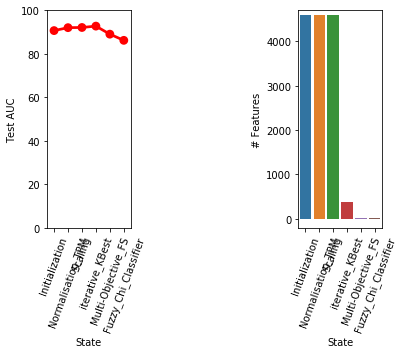

In [26]:
fig, axs = plt.subplots(1,2)   #,constrained_layout=True

sns.catplot(x="State", y="Test AUC",kind="point", data=Results_df,color='r',ax=axs[0])
axs[0].set_xticklabels(labels=axs[0].get_xticklabels(),rotation=70,size=10)
axs[0].set(ylim=(0, 100))

axs[1].set(ylim=(-200, 4700))

sns.barplot(x="State", y="# Features", data=Results_df,ax=axs[1])
axs[1].set_xticklabels(labels=axs[1].get_xticklabels(),rotation=70,size=10)
fig.subplots_adjust(wspace=2)

plt.close(2)
plt.close(3)

# plt.savefig('C:/Users/MASNA.CO/Dropbox/PAPERS/10-/Results/2Round_ruvseq_cv_RF.png', bbox_inches='tight')

# ------------End of Pipeline------------

In [ ]:
## Do not run this cell :))
# os.system("shutdown /h") #hibernate
# normalization_selected

In [ ]:
# normalization_selected = "TMM" # "TPM" "TMM"  "ruvseq_diff"    "ruvseq_cv"
# normalisation_method_chosen=normalization_selected
# Normalize (X_train,X_test,y_train,1,normalization_selected)

In [ ]:
# X_train = ensg_id_to_genes_name(X_train).transpose()
# normalisation_method_chosen = "ruvseq_diff" #  "TMM" "TPM" "ruvseq_diff"    "ruvseq_cv"
# normalisation(X_train, 0, "training", data_id="GSE89843")